In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime as dt,timedelta
import sys,os,glob
import matplotlib.image as mpimg

In [5]:
indir_mtpw = '/Users/bfildier/Data/satellite/MIMIC-TPW2/data/'
indir_goespw = '/Users/bfildier/Data/satellite/GOES-PW/'
indir_sonde_qrad = '/Users/bfildier/Data/EUREC4A/merged/radiative_profiles'

In [6]:
day = '20200126'
date = dt.strptime(day,'%Y%m%d')

lat_box = 11,16
lon_box = -60,-52

In [8]:
indir_goes_images = '/Users/bfildier/Data/satellite/GOES/images/%s'%date.strftime('%Y_%m_%d')

In [4]:
print('load rad profiles')
radprf = xr.open_dataset(os.path.join(indir_sonde_qrad,'rad_profiles.nc'))

In [14]:
print('convert times to datetime objects')
timestamps = [int(lt/1e9) for lt in radprf.launch_time.values]
times = [dt.fromtimestamp(ts)-timedelta(hours=1) for ts in timestamps] # removing 1 hour apparently necessary to match the original sonde time
# double check that (t-dt(1970,1,1)).total_seconds() gives the same time stamp
radprf = radprf.assign(launch_time=times) # reassign to object

convert times to datetime objects


In [24]:
print('load GOES images')
image_files = glob.glob(os.path.join(indir_goes_images,'*C02*00.jpg'))
image_files.sort()

images = []
for i in range(len(image_files)):
    images.append(mpimg.imread(image_files[16]))

load GOES images


In [7]:
print('load pw data')
pw_mimic_files = glob.glob(os.path.join(indir_mtpw,'*comp%s.??????.nc'%date))
pw_mimic_files.sort()

pw_goes_files = glob.glob(os.path.join(indir_goespw,'00[2-5]/*.nc'))
pw_goes_files.sort()

In [9]:
print('load and concatenate all MIMIC TPW files for that day')

# reference day time at the beginning of the year
day_ref = dt(2020,1,1)

all_pws = []

for pw_file in pw_mimic_files:

    pw_new = xr.open_dataset(pw_file)
    pw_new = pw_new.set_coords(['lonArr','latArr'])
    pw_new = pw_new.rename({'lonArr':'lon','latArr':'lat'})
    
    day_stamp = pw_file.split('.')[0][-8:]
    time_stamp = pw_file.split('.')[1]
    hour = (dt.strptime(time_stamp,'%H%M%S') - dt(1900, 1, 1))
    daytime = day + hour
    # time value to store in concatenated xarray
    total_seconds = int((daytime - day_ref).total_seconds())
    # expand dims to time dimension with new value
    pw_new = pw_new.expand_dims({'time':1})
    pw_new = pw_new.assign_coords({'time':[total_seconds]})
    # store
    all_pws.append(pw_new)
    
pw_mimic = xr.concat(all_pws,'time')

load and concatenate all MIMIC TPW files for that day


In [13]:
pw_file = pw_goes_files[0]
pw_subdir = pw_file.split('/')[-2]


'002'

In [10]:
print('load and concatenate all GOES TPW files for that day')

all_pws = []

for pw_file in pw_goes_files:

    pw_new = xr.open_dataset(pw_file)
    

<xarray.Dataset>
Dimensions:             (lat: 721, lon: 1440, time: 24)
Coordinates:
  * lon                 (lon) float32 -180.0 -179.75 -179.5 ... 179.5 179.75
  * lat                 (lat) float32 -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * time                (time) int64 2160000 2163600 2167200 ... 2239200 2242800
Data variables:
    tpwGrid             (time, lat, lon) float32 0.8125 0.8125 ... 1.375 1.375
    tpwGridPrior        (time, lat, lon) float32 0.8125 0.8125 ... 1.5 1.5
    tpwGridSubseq       (time, lat, lon) float32 0.8125 0.8125 ... 1.375 1.375
    timeAwayGridPrior   (time, lat, lon) timedelta64[ns] 00:40:00 ... 01:16:00
    timeAwayGridSubseq  (time, lat, lon) timedelta64[ns] 00:10:00 ... 00:00:00
    footGridPrior       (time, lat, lon) float32 34.0 34.0 34.0 ... 35.0 35.0
    footGridSubseq      (time, lat, lon) float32 34.0 34.0 34.0 ... 34.0 34.0
    satGridPrior        (time, lat, lon) uint8 3 3 3 3 3 3 3 3 ... 4 4 4 4 4 4 4
    satGridSubseq       (time, lat, lon) uint8 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6

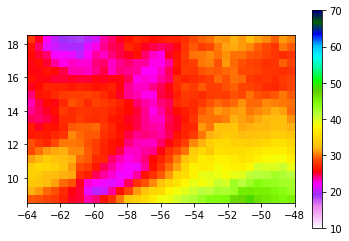

In [8]:
lat_inds = np.logical_and(pw.lat >= lat_box[0],pw.lat <= lat_box[1])
lon_inds = np.logical_and(pw.lon >= lon_box[0],pw.lon <= lon_box[1])

i_time = 15
# cmap = 'nipy_spectral_r'
# cmap = 'gist_stern_r'
# cmap = 'bone_r'
# cmap = 'magma_r'
cmap = 'gist_ncar_r'

dx = (lon_box[1]-lon_box[0])/2.
dy = (lat_box[1]-lat_box[0])/2.
extent = [lon_box[0]-dx, lon_box[-1]+dx, lat_box[0]-dy, lat_box[-1]+dy]

h = plt.imshow(pw.tpwGrid[i_time,lat_inds,lon_inds],
            origin='lower',
            extent=extent,
            cmap=cmap,
            vmin=10,vmax=70)
plt.colorbar(h)

In [9]:
radprf

<xarray.Dataset>
Dimensions:            (launch_time: 2504, zlay: 1000, zlev: 1001)
Coordinates:
    lay                int32 ...
    col                int32 ...
  * zlay               (zlay) int64 5 15 25 35 45 ... 9955 9965 9975 9985 9995
  * zlev               (zlev) int64 0 10 20 30 40 ... 9960 9970 9980 9990 10000
  * launch_time        (launch_time) datetime64[ns] 2020-01-19T16:55:14 ... 2020-02-16T04:14:33
    play               (launch_time, zlay) float64 ...
    plev               (launch_time, zlev) float64 ...
Data variables:
    latitude           (launch_time, zlay) float64 ...
    longitude          (launch_time, zlay) float64 ...
    platform           (launch_time) object ...
    z_min              (launch_time) float64 ...
    z_max              (launch_time) float64 ...
    tlay               (launch_time, zlay) float64 ...
    h2o                (launch_time, zlay) float64 ...
    sfc_emis           (launch_time) float64 ...
    sfc_alb            (launch_time) float64 ...
    sfc_t              (launch_time) float64 ...
    cos_sza            (launch_time) float64 ...
    lw_dn              (launch_time, zlev) float64 ...
    lw_up              (launch_time, zlev) float64 ...
    lw_net             (launch_time, zlev) float64 ...
    sw_dn              (launch_time, zlev) float64 ...
    sw_up              (launch_time, zlev) float64 ...
    sw_net             (launch_time, zlev) float64 ...
    relative_humidity  (launch_time, zlay) float64 ...
    wind_speed         (launch_time, zlay) float64 ...
    wind_direction     (launch_time, zlay) float64 ...
    u_wind             (launch_time, zlay) float64 ...
    v_wind             (launch_time, zlay) float64 ...
    co2                (launch_time, zlay) float64 ...
    ch4                (launch_time, zlay) float64 ...
    n2o                (launch_time, zlay) float64 ...
    o3                 (launch_time, zlay) float64 ...
    o2                 (launch_time, zlay) float64 ...
    n2                 (launch_time, zlay) float64 ...
    co                 (launch_time, zlay) float64 ...
    mr                 (launch_time, zlay) float64 ...
    rho                (launch_time, zlay) float64 ...
    q_rad              (launch_time, zlay) float64 ...
    q_rad_lw           (launch_time, zlay) float64 ...
    q_rad_sw           (launch_time, zlay) float64 ...

In [39]:
print("calculate pw for each sonde")

# mask_40m = radprf.z_min <= 40

q = radprf.h2o[mask_40m]
plev = radprf.plev[mask_40m]
dplev = -np.diff(plev,axis=1)
pw = (q*dplev/9.81).sum(axis=1)

calculate pw for each sonde


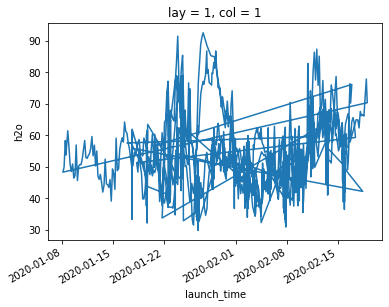

In [41]:
pw.plot()